In [1]:
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image, ImageOps
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel

# input_image = Image.open("text_diffuser/assets/test01.jpeg").convert("RGB").resize((512,512))
hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
input_image = load_image(hf_dataset_base_url + '3.jpg')
guidance_scale = 7.5

""" Change the text in the original image by coordinates and  """

sample_text="MLVU Project"
prompt = "A dog and a cat"



# for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
coordinates=[[256, 256]] 
arg_textseg = make_text_segmentation_args(
    model_type='vit_l',
    checkpoint_path='sam_tss_l_hiertext.pth',
    input_size=input_image.size,
    hier_det=False,
)

arg_maskgen = make_text_segmentation_args(
    model_type='vit_h',
    checkpoint_path='word_detection_totaltext.pth',
    input_size=input_image.size,
    hier_det=True,
)

out = gen_mask_only(input_image, sample_text=sample_text, coordinates=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)


img = out
img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
gray = img
_, binary_tss = cv2.threshold(
    gray, 50, 255, cv2.THRESH_BINARY
)


_, binary_bbox = cv2.threshold(
    gray, 200, 255, cv2.THRESH_BINARY
)

binary_tss_pil = Image.fromarray(binary_tss, 'L')
inverted_tss_pil = ImageOps.invert(binary_tss_pil)
binary_bbox_pil = Image.fromarray(binary_bbox, 'L')



2024-06-08 18:16:22.093513: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-08 18:16:22.484181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 18:16:22.484244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 18:16:22.485730: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-08 18:16:22.631379: I tensorflow/core/platform/cpu_feature_g

Freeze image encoder.
<All keys matched successfully>
Freeze image encoder.
<All keys matched successfully>


/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 4/4 [00:01<00:00,  2.16it/s]

Mask shape:  (512, 512)


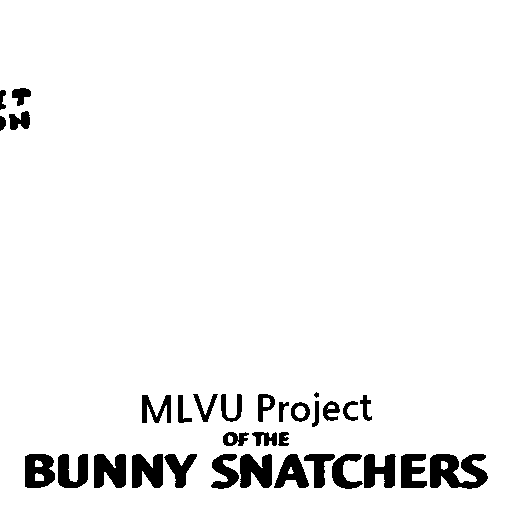

In [2]:
display(binary_tss_pil)

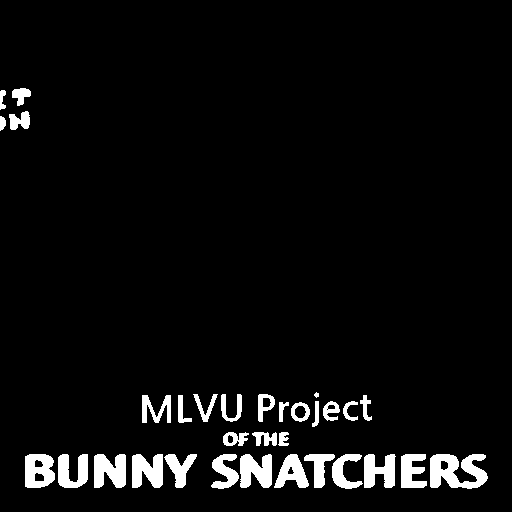

In [3]:
display(inverted_tss_pil)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

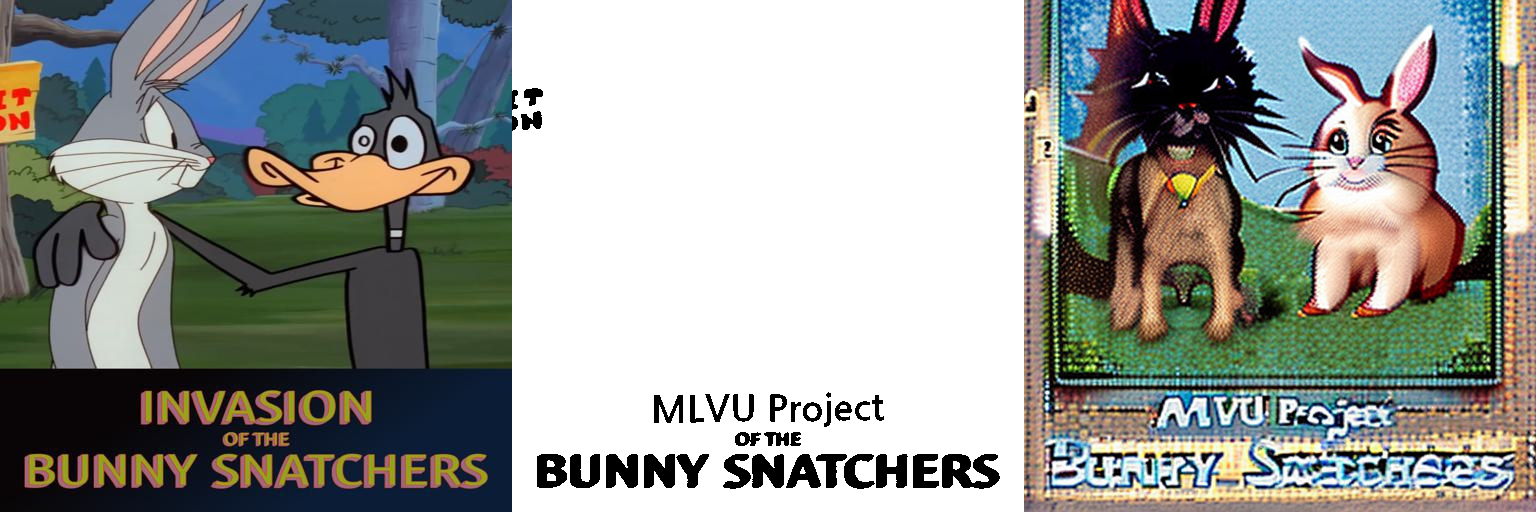

In [4]:
from diffusers import ControlNetModel, EulerAncestralDiscreteScheduler, StableDiffusionControlNetPipeline, UniPCMultistepScheduler
from diffusers.utils import make_image_grid
from PIL import ImageOps

controlnet = ControlNetModel.from_pretrained(
        "GoGiants1/GlyphControls", 
        use_safetensors=True,
        revision="textcaps5K_epoch_40_ema",
        torch_dtype=torch.float16,
        variant="fp16"
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2", 
    controlnet=controlnet, 
    torch_dtype=torch.float16, 
    use_safetensors=True, 
    variant="fp16",
)
controlnet_prompt = prompt + " '" +  sample_text + " OF THE BUNNY AND SNATCHERS'"
# controlnet_prompt = prompt
generator = torch.Generator(device="cpu").manual_seed(42)
pipe.enable_model_cpu_offload()

control_image = Image.fromarray(binary_tss)
output = pipe(
    prompt=controlnet_prompt,
    image=control_image,
    controlnet_conditioning_scale=1.0, 
    generator=generator,
    guidance_scale=guidance_scale,
).images[0]

out_dir = f"experiments/glyph-control/{controlnet_prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/output_cfg_{guidance_scale}.png", "PNG")
control_image.save(f"{out_dir}/control.png", "gPNG")
input_image.save(f"{out_dir}/input.png", "PNG")

img = make_image_grid([input_image, control_image, output], rows=1, cols=3)

display(img)

In [5]:
# Text-diffuser without style transfer

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)

pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
generator = torch.Generator(device="cpu").manual_seed(42)
# visual_text_prompt = 'MLVU Project OF THE BUNNY AND SNATCHERS'
output = pipe(
    prompt=prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)


output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


  0%|          | 0/50 [00:00<?, ?it/s]

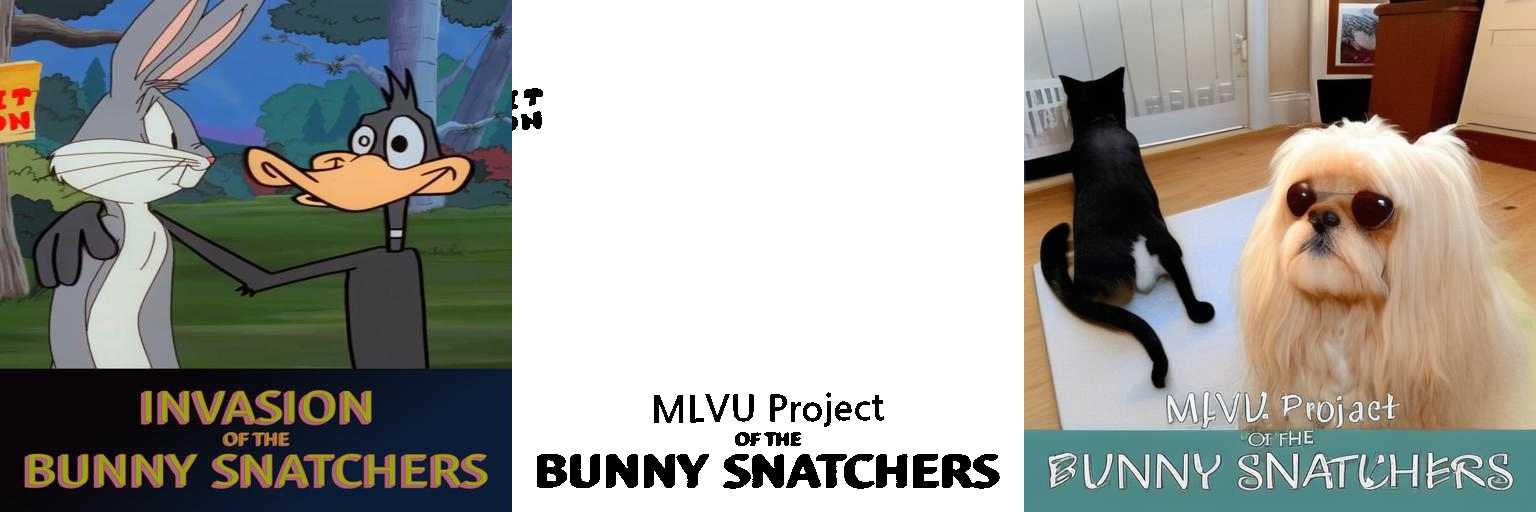

In [6]:
from diffusers.utils import make_image_grid

grid_img = make_image_grid([input_image, binary_tss_pil, output], rows=1, cols=3)
display(grid_img)

In [7]:
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
generator = torch.Generator(device="cpu").manual_seed(42)
pipe.enable_model_cpu_offload()
image = pipe(prompt, guidance_scale=guidance_scale, height=512, width=512, generator=generator).images[0]

out_dir = f"experiments/sd-15-base/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
image.save(f"{out_dir}/output.png", "PNG")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

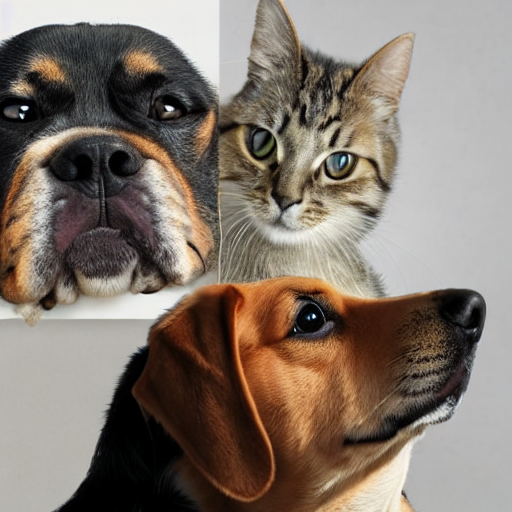

In [8]:
display(image)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .
/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

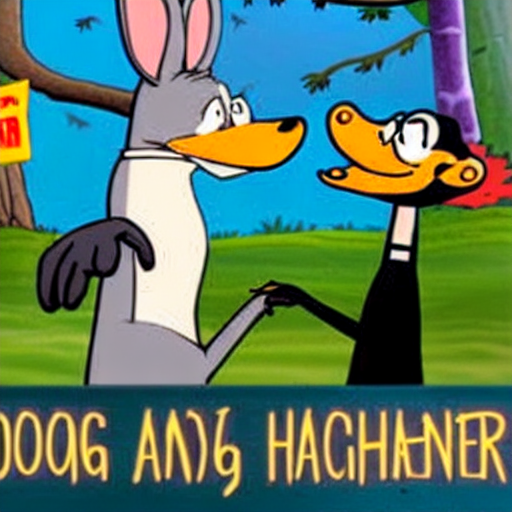

In [9]:
# SD 1.5 + Style Transfer (Naive Version)
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, safety_checker=None, torch_dtype=torch.float32)
generator = torch.Generator(device="cpu").manual_seed(42)

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        "ip-adapter-plus_sd15.safetensors",
    ],
)

pipe.set_ip_adapter_scale(0.7)

pipe.enable_model_cpu_offload()

hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
input_image = load_image(hf_dataset_base_url + '3.jpg')

image = pipe(prompt, ip_adapter_image=[input_image], guidance_scale=guidance_scale, height=512, width=512, generator=generator).images[0]

out_dir = f"experiments/sd-15-ip-adapter/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# image.save(f"{out_dir}/output_cfg_{guidance_scale}_{block_type}_block{block_idx}_attn{attn_idx}.png", "PNG")
image.save(f"{out_dir}/output_cfg_{guidance_scale}_ip_naive.png", "PNG")
display(image)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

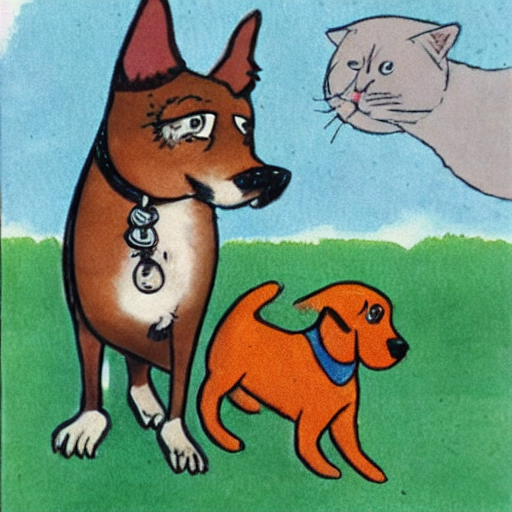

In [10]:
# SD 1.5 + Style Transfer (Without Rendered Text, Use only Style layer)
from diffusers import StableDiffusionPipeline
import torch

model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, safety_checker=None, torch_dtype=torch.float32)
generator = torch.Generator(device="cpu").manual_seed(42)

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        "ip-adapter-plus_sd15.safetensors",
    ],
)

scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0.5, 0.5],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
}
# block_type = "up"
# block_idx = 3
# attn_idx = 2

# if block_type == "mid":
#     scale[block_type] = 0.7
# else:
#     scale[block_type]["block_" + str(block_idx)][attn_idx]=0.7

# pipe.set_ip_adapter_scale(0.7)
pipe.set_ip_adapter_scale(scale)

pipe.enable_model_cpu_offload()

hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
input_image = load_image(hf_dataset_base_url + '3.jpg')

image = pipe(prompt, ip_adapter_image=[input_image], guidance_scale=guidance_scale, height=512, width=512, generator=generator).images[0]

out_dir = f"experiments/sd-15-ip-adapter/{prompt}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
# image.save(f"{out_dir}/output_cfg_{guidance_scale}_{block_type}_block{block_idx}_attn{attn_idx}.png", "PNG")
# image.save(f"{out_dir}/output_cfg_{guidance_scale}_ip_all.png", "PNG")
image.save(f"{out_dir}/output_optimal_0.5.png", "PNG")
display(image)

In [11]:
"""
scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
    
}
"""


def get_file_name_from_scale(scale:dict):
    name = ""
    for k, v in scale.items():
        if k == "mid":
            if v[0] != 0:
                name += "_mid_" + str(v[0])
        else:
            for block_name, block_values in v.items():
                for idx, value in enumerate(block_values):
                    if value != 0:
                        name += f"_{k}_{block_name}_attn{idx}_{value}"
    
    return name

In [16]:
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
import copy

# hf_dataset_base_url = "https://huggingface.co/datasets/GoGiants1/TMDBEval500/resolve/main/TMDBEval500/images/"
# input_image = load_image(hf_dataset_base_url + '3.jpg')
# guidance_scale = 5

# """ Change the text in the original image by coordinates and  """

# sample_text="MLVU Team 8"
# # prompt = "a dog and a cat"
# prompt = "a dog and a cat"



# # for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
# coordinates=[[256, 256]] 
# arg_textseg = make_text_segmentation_args(
#     model_type='vit_l',
#     checkpoint_path='sam_tss_l_hiertext.pth',
#     input_size=input_image.size,
#     hier_det=False,
# )

# arg_maskgen = make_text_segmentation_args(
#     model_type='vit_h',
#     checkpoint_path='word_detection_totaltext.pth',
#     input_size=input_image.size,
#     hier_det=True,
# )

# out = gen_mask_only(input_image, sample_text=sample_text, coordinates=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)


# img = out
# img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_NEAREST)
# gray = img
# _, binary_tss = cv2.threshold(
#     gray, 50, 255, cv2.THRESH_BINARY
# )

# _, binary_bbox = cv2.threshold(
#     gray, 200, 255, cv2.THRESH_BINARY
# )

# binary_tss_pil = Image.fromarray(binary_tss, 'L')
# binary_bbox_pil = Image.fromarray(binary_bbox, 'L')

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)


# pipe.to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        # "ip-adapter_sd15.bin",
        # "ip-adapter_sd15.bin",
        "ip-adapter-plus_sd15.safetensors",
        
    ],
    torch_dtype=torch.float32
)

scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
    
}
blocks = ["down", "mid", "up"]
block_nums = {
    "down": range(3),
    "up": range(1, 4)
}
block_max_attn = {
    "down": 2,
    "up": 3
}


pipe.enable_model_cpu_offload()


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
generator = torch.Generator(device="cpu").manual_seed(42)

ip_scale = 0.5

out_dir = f"experiments/td-15-style-transfer/block-test/{prompt}/ip_scale{ip_scale}"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for block in blocks:
    if block == "mid":
        scale_copy = copy.deepcopy(scale)
        scale_copy[block] = ip_scale
        pipe.set_ip_adapter_scale(scale_copy)
        output = pipe(
                    prompt=prompt,
                    input_image=input_image,
                    text_mask_image=text_mask_image,
                    ip_adapter_image=[input_image],
                    width=512,
                    height=512,
                    guidance_scale=guidance_scale,
                    generator=generator,
                    torch_dtype=torch.float32
                ).images[0]
        output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{block}_block{block_num}_attn{attn_idx}.png", "PNG")
    else:
        for block_num in block_nums[block]:
            for attn_idx in range(block_max_attn[block]):
                scale_copy = copy.deepcopy(scale)
                scale_copy[block]["block_" + str(block_num)][attn_idx]=ip_scale
                pipe.set_ip_adapter_scale(scale_copy)
            
                output = pipe(
                    prompt=prompt,
                    input_image=input_image,
                    text_mask_image=text_mask_image,
                    ip_adapter_image=[input_image],
                    width=512,
                    height=512,
                    guidance_scale=guidance_scale,
                    generator=generator,
                    torch_dtype=torch.float32
                ).images[0]
                output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{block}_block{block_num}_attn{attn_idx}.png", "PNG")

    


    
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
"""
scale = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0],
    "up": {
        "block_1" : [0,0,0],
        "block_2" : [0,0,0],
        "block_3" : [0,0,0]
    }
    
}
"""


def get_file_name_from_scale(scale:dict):
    name = ""
    for k, v in scale.items():
        if k == "mid":
            if v[0] != 0:
                name += "_mid_" + str(v[0])
        else:
            for block_name, block_values in v.items():
                for idx, value in enumerate(block_values):
                    if value != 0:
                        block_idx = block_name.split("_")[-1]
                        name += f"_{k}_{block_idx}_attn{idx}_{value}"
    
    return name

In [53]:
# Our Final Pipeline (TODO: EVAL)

import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
import copy
from datetime import datetime
import json


timestamp = datetime.now().strftime("%Y%m%d%H%M%S")

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)


# pipe.to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
        "models",
    ],
    weight_name=[
        # "ip-adapter_sd15.bin",
        # "ip-adapter_sd15.bin",
        "ip-adapter-plus_sd15.safetensors",
        "ip-adapter-plus_sd15.safetensors",
    ],
    torch_dtype=torch.float32
)

scale_for_bg = {
    "down": { 
        "block_0": [0.1, 0.1],
        "block_1": [0.1, 0.1],
        "block_2": [0.4, 0.1],
    },
    "mid": [0.1],
    "up": {
        "block_1" : [0.1, 0.1, 0.1],
        "block_2" : [0, 0, 0],
        "block_3" : [0.1, 0.1, 0.1]
    }
    
}

scale_for_text = {
    "down": { 
        "block_0": [0, 0],
        "block_1": [0, 0],
        "block_2": [0, 0],
    },
    "mid": [0.7],
    "up": {
        "block_1" : [0, 0, 0],
        "block_2" : [0.7, 0, 0],
        "block_3" : [0.7, 0.7, 0]
    }
}
pipe.set_ip_adapter_scale([scale_for_bg, scale_for_text])
# pipe.set_ip_adapter_scale([scale, scale])


pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
seed = 42
generator = torch.Generator(device="cpu").manual_seed(seed)

# negative_prompt ="ugly, deformed, noisy, blurry, distorted, out of focus, bad anatomy, extra limbs, poorly drawn face, poorly drawn hands, missing fingers, high contrast, over saturated, glossy, Photoshop, sketch, sketches, video game, cgi, canvas frame, signature, username, artist name"
output = pipe(
    prompt=prompt,
    # negative_prompt=negative_prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image,input_image],
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15-style-transfer/{prompt}/plus-model"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/{timestamp}.png", "PNG")
scale_info = {
    "background_scale": scale_for_bg,
    "text_scale": scale_for_text,
    "prompt": prompt,
    "guidance_scale": guidance_scale,
    "seed": seed,
    "scheduler": "DDPM"
}
with open(f"{out_dir}/{timestamp}_scale_info.json", 'w') as f:
    json.dump(scale_info, f)

# output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{get_file_name_from_scale(scale)}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


  0%|          | 0/50 [00:00<?, ?it/s]

cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 a

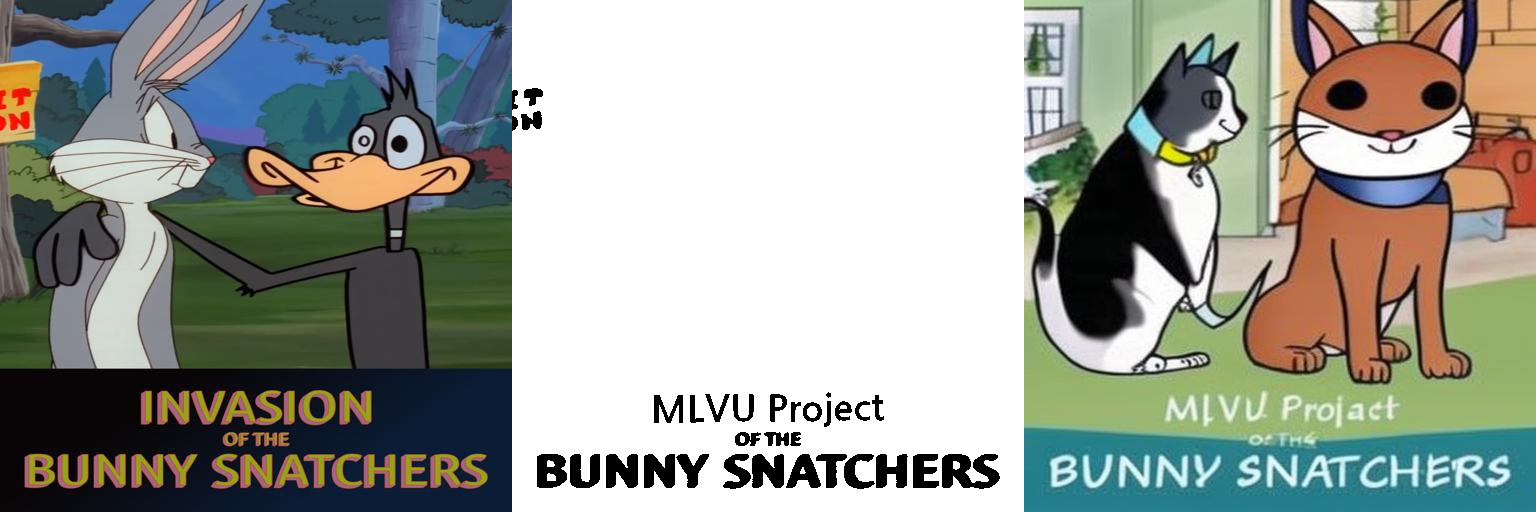

In [54]:
from diffusers.utils import make_image_grid

grid_img = make_image_grid([input_image, binary_tss_pil, output], rows=1, cols=3)
display(grid_img)

In [11]:
# Text Diffuser with fine-grained mask (TODO: EVAL)
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
import copy
from datetime import datetime
import json


timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)


pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
        "models",
    ],
    weight_name=[
        "ip-adapter-plus_sd15.safetensors",
        "ip-adapter-plus_sd15.safetensors",
    ],
    torch_dtype=torch.float32
)

pipe.set_ip_adapter_scale([0.2, 0.2])


pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
seed = 42
generator = torch.Generator(device="cpu").manual_seed(seed)

# negative_prompt ="ugly, deformed, noisy, blurry, distorted, out of focus, bad anatomy, extra limbs, poorly drawn face, poorly drawn hands, missing fingers, high contrast, over saturated, glossy, Photoshop, sketch, sketches, video game, cgi, canvas frame, signature, username, artist name"
output = pipe(
    prompt=prompt,
    # negative_prompt=negative_prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image, input_image],
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15-style-transfer/{prompt}/plus-model/two_masks"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/{timestamp}.png", "PNG")
scale_info = {
    "prompt": prompt,
    "guidance_scale": guidance_scale,
    "seed": seed,
    "scheduler": "DDPM"
}
with open(f"{out_dir}/{timestamp}_scale_info.json", 'w') as f:
    json.dump(scale_info, f)

# output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{get_file_name_from_scale(scale)}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


  0%|          | 0/50 [00:00<?, ?it/s]

cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 and will be ignored.
cross_attention_kwargs ['ip_adapter_masks'] are not expected by AttnProcessor2_0 a

In [10]:
# Text Diffuser + style transfer without masks (TODO: EVAL)
import cv2
import numpy as np
import torch
from accelerate import PartialState
from IPython.display import display
from PIL import Image
import os
from attn_map_utils import register_cross_attention_hook
from diffusers import AutoencoderKL, DDPMScheduler, DPMSolverMultistepScheduler, EulerAncestralDiscreteScheduler
from diffusers.utils import load_image
from hi_sam.text_segmentation import make_text_segmentation_args
from text_diffuser.generate_mask_only import gen_mask_only
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel
import copy
from datetime import datetime
import json


timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", use_safetensors=True)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    vae=vae,
    safety_checker=None,
    torch_dtype=torch.float32,
)
# distributed_state = PartialState()
# pipe.to(distributed_state.device)


# pipe.to("cuda")

pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
    ],
    weight_name=[
        # "ip-adapter_sd15.bin",
        # "ip-adapter_sd15.bin",
        "ip-adapter-plus_sd15.safetensors",
    ],
    torch_dtype=torch.float32
)

pipe.set_ip_adapter_scale([0.2])


pipe.enable_model_cpu_offload()

# pipe.unet = register_cross_attention_hook(pipe.unet)


""" Change the text in the original image by coordinates and  """

text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config, use_karras_sigmas=True, algorithm_type="sde-dpmsolver++")
seed = 42
generator = torch.Generator(device="cpu").manual_seed(seed)

# negative_prompt ="ugly, deformed, noisy, blurry, distorted, out of focus, bad anatomy, extra limbs, poorly drawn face, poorly drawn hands, missing fingers, high contrast, over saturated, glossy, Photoshop, sketch, sketches, video game, cgi, canvas frame, signature, username, artist name"
output = pipe(
    prompt=prompt,
    # negative_prompt=negative_prompt,
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image],
    width=512,
    height=512,
    guidance_scale=guidance_scale,
    generator=generator,
    torch_dtype=torch.float32
).images[0]

out_dir = f"experiments/td-15-style-transfer/{prompt}/plus-model/one_mask"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

output.save(f"{out_dir}/{timestamp}.png", "PNG")
scale_info = {
    "prompt": prompt,
    "guidance_scale": guidance_scale,
    "seed": seed,
    "scheduler": "DDPM"
}
with open(f"{out_dir}/{timestamp}_scale_info.json", 'w') as f:
    json.dump(scale_info, f)

# output.save(f"{out_dir}/{sample_text}_output_cfg_{guidance_scale}_{get_file_name_from_scale(scale)}.png", "PNG")
input_image.save(f"{out_dir}/input.png", "PNG")
binary_tss_pil.save(f"{out_dir}/{sample_text}_text_mask.png", "PNG")



Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'text_diffuser.pipeline_text_diffuser_sd15.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Check text_segmenter.pth...


  0%|          | 0/50 [00:00<?, ?it/s]